In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

In [33]:
def generate(string): 
    a = np.array([[1, 1, 2],[0, 1, 1],[0,-3,-2]])
    b = np.array([[-2, 0, -1],[-5, 1, -1],[3,0,1]])

    maxMats = 50
    dataPoints = 10000
    prevMat = -1


    for j in range(dataPoints):
        nextMat = random.randint(0,1)
        if nextMat == 0: 
            mat = a
            prevMat = 0
        elif nextMat == 1:
            mat = b
            prevMat = 1
        numOfMatrices = random.randint(1, maxMats)
        for i in range(numOfMatrices): 
            nextMat = random.randint(0,1)
            if (nextMat == 0):
                mat = np.matmul(a, mat)
                prevMat = nextMat
            elif (nextMat == 1):
                mat = np.matmul(b, mat)
                prevMat = nextMat
        if j == 0: 
            df = pd.DataFrame([[mat[0][0],mat[0][1],mat[0][2], mat[1][0],mat[1][1],mat[1][2],mat[2][0],mat[2][1],mat[2][2], prevMat]], columns = ['00', '01', '02','10','11','12', '20', '21','22',"last"])
        else: 
            df = pd.concat([df, pd.DataFrame([[mat[0][0],mat[0][1],mat[0][2], mat[1][0],mat[1][1],mat[1][2],mat[2][0],mat[2][1],mat[2][2], prevMat]],columns = ['00', '01', '02','10','11','12', '20', '21','22',"last"])])
# mat[0][0] = mat[0][0]  % 7
# mat [0][1] = mat[0][1]  % 7
# mat[0][2] = mat[0][2]  % 7
# mat [1][0] = mat[1][0]  % 7
# mat [1][1] = mat[1][1]  % 7
# mat [1][1] = mat[1][1]  % 7
    df.to_csv(string, index = False)

In [34]:
# code adapted from ChatGPT

# Define your neural network model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()

        self.step1 = nn.Linear(9, 128, bias=True)
        self.step2 = nn.ReLU()
        self.step3 = nn.Linear(128, 64, bias=True)
        self.step4 = nn.ReLU()
        self.step5 = nn.Linear(64, 16, bias=True)
        self.step6 = nn.ReLU()
        self.step7 = nn.Linear(16, 1, bias=True)
        self.step8 = nn.Sigmoid()

    def forward(self, x):

        # RUN IT ON A GPU if it exists
        if torch.cuda.is_available():
            x = x.to("cuda")

        x = self.step1(x)
        x = self.step2(x)
        x = self.step3(x)
        x = self.step4(x)
        x = self.step5(x)
        x = self.step6(x)
        x = self.step7(x)
        x = self.step8(x)
        
        return x

def train_model(inputs, desired_outputs, num_epochs=100, learning_rate=0.02, momentum=0.9, viz_accuracy=False):
    # Convert inputs and desired_outputs to PyTorch tensors
    inputs = torch.tensor(inputs, dtype=torch.float32)
    desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)
    
    # Create a DataLoader to handle batching (if needed)
    dataset = TensorDataset(inputs, desired_outputs)
    dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)  # Adjust batch_size as needed
    
    # Initialize the model
    model = SimpleModel()
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()  # Mean Squared Error loss
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_inputs, batch_desired_outputs in dataloader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_inputs)  # Forward pass
            loss = criterion(outputs, batch_desired_outputs)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the model's parameters
            cur_item = loss.item()
            total_loss += cur_item
        
        # Print the average loss for this epoch
        print(f"total loss: {total_loss}")
        average_loss = total_loss / len(dataloader)
        if viz_accuracy:
            losses.append(average_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')
    
    if viz_accuracy:
        plt.scatter(x=range(1, len(losses)+1), y=losses)
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.show()

    # Return the trained model
    return model

In [35]:
generate('matrices_train.csv')
generate('matrices_test.csv')
df = pd.read_csv("matrices_train.csv")
just_input = df.drop('last', axis=1)

# adapted from https://stackoverflow.com/questions/43898035/pandas-combine-column-values-into-a-list-in-a-new-column
input_data = np.array(just_input.values.tolist())
desired_output = torch.tensor(df['last'].tolist(), dtype=torch.float32).long()

/var/folders/xs/6yx8fshd7_v5fg9sl09cfpdh0000gn/T/ipykernel_77585/3187993261.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


total loss: 3.66562220454216
Epoch [1/500], Loss: 0.3666
total loss: 3.6760697960853577
Epoch [2/500], Loss: 0.3676
total loss: 3.392651081085205
Epoch [3/500], Loss: 0.3393
total loss: 2.7086480259895325
Epoch [4/500], Loss: 0.2709
total loss: 2.5005653649568558
Epoch [5/500], Loss: 0.2501
total loss: 2.5002222806215286
Epoch [6/500], Loss: 0.2500
total loss: 2.5000112801790237
Epoch [7/500], Loss: 0.2500
total loss: 2.4998519718647003
Epoch [8/500], Loss: 0.2500
total loss: 2.499888926744461
Epoch [9/500], Loss: 0.2500
total loss: 2.499765083193779
Epoch [10/500], Loss: 0.2500
total loss: 2.49977245926857
Epoch [11/500], Loss: 0.2500
total loss: 2.499749854207039
Epoch [12/500], Loss: 0.2500
total loss: 2.4997647404670715
Epoch [13/500], Loss: 0.2500
total loss: 2.4997446537017822
Epoch [14/500], Loss: 0.2500
total loss: 2.499747484922409
Epoch [15/500], Loss: 0.2500
total loss: 2.4997736364603043
Epoch [16/500], Loss: 0.2500
total loss: 2.4997455775737762
Epoch [17/500], Loss: 0.250

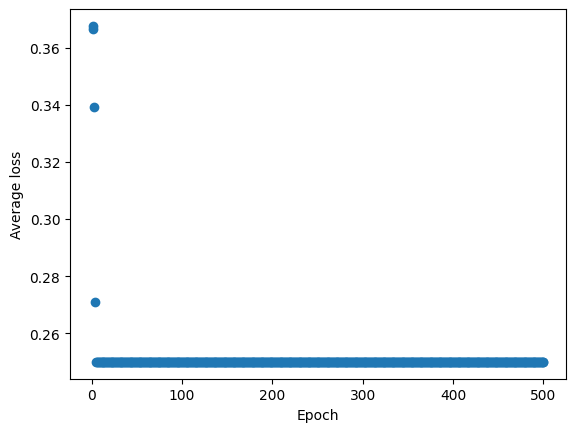

In [36]:

# Train the model
trained_model = train_model(input_data, desired_output, 500, viz_accuracy=True)


In [37]:
def test_model(trained_model, new_data, expected_result):
    test_input = torch.tensor(new_data, dtype=torch.float32)

    test_output = trained_model(test_input)

    predicted_classes = torch.argmax(test_output, dim=1)

    test_output_compare = torch.tensor(expected_result, dtype=torch.int)

    return float(sum(test_output_compare == predicted_classes)/len(test_input))

In [38]:
test_df = pd.read_csv("matrices_test.csv")
just_input_test = test_df.drop('last', axis=1)
input_data_test = np.array(just_input_test.values.tolist())
desired_output = torch.tensor(test_df['last'].tolist(), dtype=torch.float32).long()

test_model(trained_model, input_data_test, desired_output)

/var/folders/xs/6yx8fshd7_v5fg9sl09cfpdh0000gn/T/ipykernel_77585/875939923.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_output_compare = torch.tensor(expected_result, dtype=torch.int)


0.49959999322891235